In [42]:
import torch
import torch.nn.functional as F
from torch import Tensor
import random
from mynn import *
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
from collections import Counter


rndSeed = 42
contextSize = 3
trRatio = 0.8
devRatio = 0.9
embeddingSize = 10 # the dimensionality of the character embedding vectors
hiddenLayerSize = 200 # the number of neurons in the hidden layer of the MLP
maxTrainingSteps = 100_00000
trainingBatchSize = 128
rndSeed2 = 2147483647
g = torch.Generator().manual_seed(rndSeed2)
gSampling = torch.Generator().manual_seed(rndSeed2 + 10)


words = readFileSplitByLine('sk-names.txt')
random.seed(rndSeed)
random.shuffle(words)
print('first few words:\n', words[:5])

lenWords = len(words);
print('lenWords:\n', lenWords)

allPossibleChars = sorted(list(set(''.join(words))))
print('allPossibleChars:\n', allPossibleChars)

stoi = sToI(allPossibleChars)
print('stoi:\n', stoi)

itos = iToS(stoi)
print('itos:\n', itos)

vocabularySize = len(itos)
print('vocabularySize:\n', vocabularySize)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos)
print('data set training:\n', trX.shape, trY.shape, lenTrain, trWords[:3])

endDev = int(devRatio * lenWords)
devWords = words[lenTrain:endDev];
devX, devY = buildDataSet(devWords, contextSize, stoi, itos)
print('data set dev:\n', endDev - lenTrain, devX.shape, devY.shape, devWords[:3])

lenTest = lenWords - endDev
tstWords = words[endDev:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos)
print('data set test:\n', lenTest, tstX.shape, tstY.shape, tstWords[:3])

np = makeNetwork(g, vocabularySize, embeddingSize, contextSize, hiddenLayerSize)
print('parametersCount:\n', sum(p.nelement() for p in np.all))

def trLoss():
    return getLoss(np, np.C[trX], embeddingSize, contextSize, trY)

def devLoss():
    return getLoss(np, np.C[trX], embeddingSize, contextSize, trY)

def tstLoss():
    return getLoss(np, np.C[tstX], embeddingSize, contextSize, tstY)

class Losses:
    tr: Loss
    dev: Loss
    tst: Loss

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.dev = devLoss()
    l.tst = tstLoss()
    return l

def printLosses():
    losses = getLosses()
    print('losses:\n', \
        losses.tr.loss.item(), \
        losses.dev.loss.item(), \
        losses.tst.loss.item());\

printLosses()

def calculate_entropy(dataset):
    # Flatten the dataset and create a frequency distribution
    frequency_distribution = Counter(''.join(dataset))
    
    # Normalize the frequency distribution to get a probability distribution
    probabilities = NP.array(list(frequency_distribution.values())) / sum(frequency_distribution.values())
    
    print('probabilities ', probabilities)
    # Calculate the entropy
    entropy = -torch.sum(torch.tensor(probabilities) * torch.log2(torch.tensor(probabilities)))
    
    return entropy

print('xxxx ', calculate_entropy(words))

lr = 0.1;
lre = torch.linspace(-3, 0, maxTrainingSteps)
lrs = 10 ** lre
lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
fr: ForwardPassResult = ForwardPassResult()

for i in range(maxTrainingSteps):    

    miniBatchIxs = torch.randint(0, trX.shape[0], (trainingBatchSize,), generator=g)
    fr = forwardPass(np, trX, miniBatchIxs, embeddingSize, contextSize, trY)  
    backwardPass(np.all, fr.loss)
    
    stepIx.append(i)
    lossAtIx.append(fr.loss.item())
    logLossAtIx.append(fr.loss.log10().item())

    #lr = lrs[i].item()
    #lrAtIx.append(lrs[i].item())
    
    updateNet(np.all, i, lr)
    
    if (((i * trainingBatchSize) > (lenWords * 10)) and (fr.loss.item() < 1.7)):
      print("break", i)
      break

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#print('best learning rate:\n', bestLr)
print('emb.shape:\n', fr.emb.shape)
print('h.shape:\n', fr.h.shape)
print('logits.shape:\n', fr.logits.shape)
printLosses()


first few words:
 ['Miida', 'Gaivile', 'Neta', 'Honorát', 'Evyenous']
lenWords:
 3018
allPossibleChars:
 [' ', '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'Ü', 'á', 'ä', 'é', 'í', 'ó', 'ö', 'ú', 'ü', 'ý', 'Č', 'č', 'ě', 'ľ', 'Ł', 'ł', 'ň', 'Ő', 'ő', 'ř', 'Š', 'š', 'Ž', 'ž']
stoi:
 {'.': 0, ' ': 1, '-': 2, 'A': 3, 'B': 4, 'C': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'I': 11, 'J': 12, 'K': 13, 'L': 14, 'M': 15, 'N': 16, 'O': 17, 'P': 18, 'R': 19, 'S': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27, 'a': 28, 'b': 29, 'c': 30, 'd': 31, 'e': 32, 'f': 33, 'g': 34, 'h': 35, 'i': 36, 'j': 37, 'k': 38, 'l': 39, 'm': 40, 'n': 41, 'o': 42, 'p': 43, 'q': 44, 'r': 45, 's': 46, 't': 47, 'u': 48, 'v': 49, 'w': 50, 'x': 51, 'y': 52, 'z': 53, 'Á': 54, 'É': 5

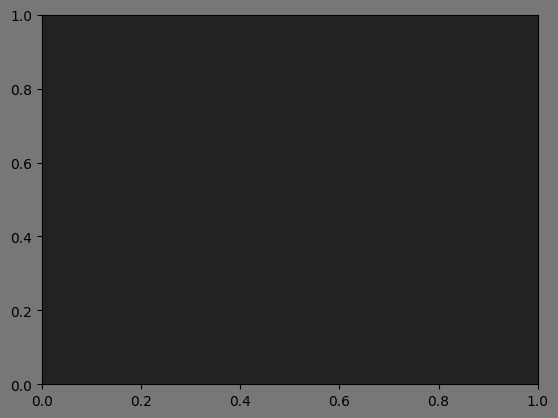

In [44]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
#ax.plot(lrAtIx, lossAtIx)
plt.show()

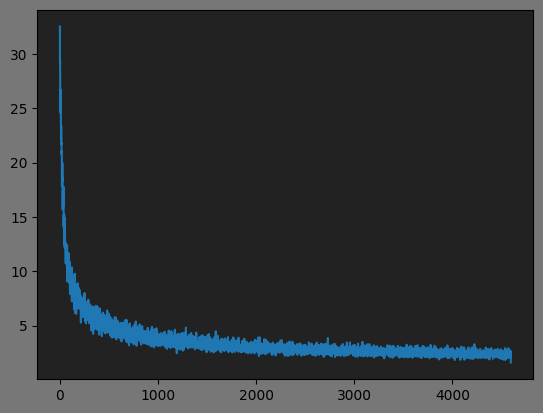

In [45]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepIx, lossAtIx)
plt.show()

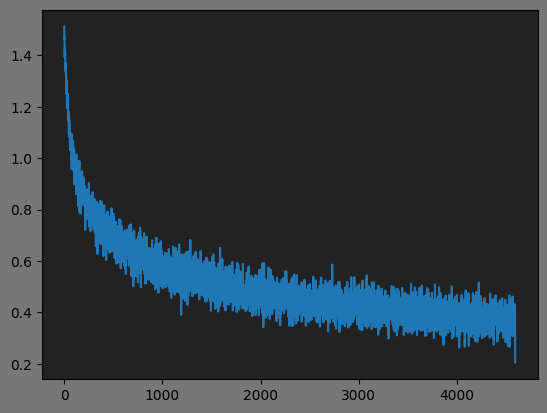

In [46]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepIx, logLossAtIx)
plt.show()

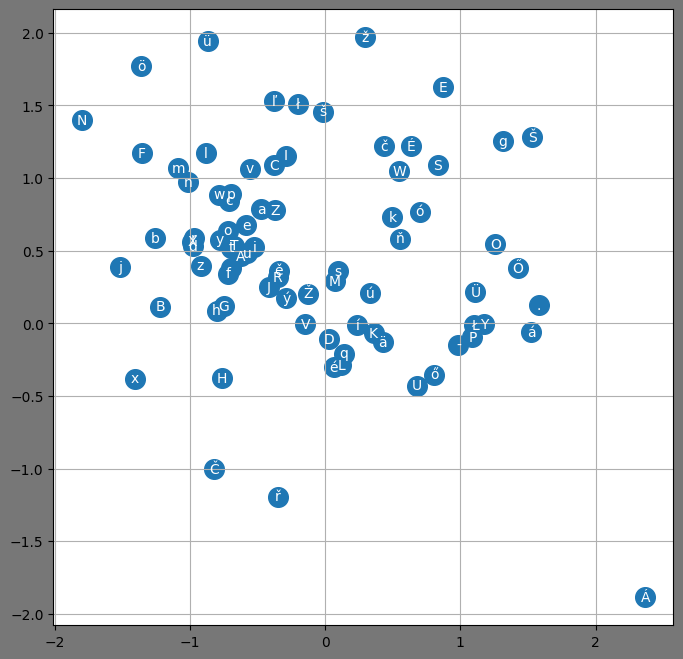

In [47]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('#777777')
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [48]:
sample(np, gSampling, contextSize, itos, 20)

Adas.
Kriti.
Adardanharlu.
ReinheNis.
Birt.
Rokarich.
Aboal.
OvéłBZugmito.
Aobdenent.
Kel.
Boada.
Julinas.
Deard.
Gen.
Redmanr.
Sivosindenevgevislava.
Dionnis.
Adold.
Swearom.
Madynán.


In [49]:
np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

(torch.Size([80, 10]),
 torch.Size([17953, 3]),
 torch.Size([17953, 3, 10]),
 tensor([[ 1.5820,  0.1252,  0.5744, -0.4211, -0.4591,  0.1142, -1.6152,  1.0735,
          -0.7302,  1.0442],
         [-0.6938,  0.3817, -0.2391, -0.4342,  1.1473,  3.2411,  1.1163, -1.5683,
           0.5261, -0.9849],
         [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
          -1.2199,  0.3031],
         [-0.6227,  0.4639,  0.0888,  0.4481, -0.8255, -0.2135, -1.3607,  1.0934,
          -1.5190,  0.5870],
         [-1.2208,  0.1143, -0.2138,  0.3310, -0.7590,  0.4786,  0.2402,  0.1932,
          -0.0247, -0.7631]], grad_fn=<SliceBackward0>),
 tensor([[ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 36],
         [15, 36, 36],
         [36, 36, 31]]),
 tensor([[[ 1.5820,  0.1252,  0.5744, -0.4211, -0.4591,  0.1142, -1.6152,
            1.0735, -0.7302,  1.0442],
          [ 1.5820,  0.1252,  0.5744, -0.4211, -0.4591,  0.1142, -1.6152,
            1.0735, -0.7302,  1.0442

In [50]:
# Let's suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let's print the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
